# 6 Explaining the challenge task
**Estimated time to run through notebook is 20 minutes** 

This notebook shows how to
-  [Load libraries, predefine some functions, and load the manifest](#preprocessing)
-  [6.1 Mitotic cells in the dataset](#make)
-  [6.2 Make a simple classifier](#rf)
-  [6.3 Here are the hackathon tasks](#tasks)
-  [Conclusion](#end)

#### Resources
- Previous chapters

## <a id='preprocessing'></a>Load libraries, predefine some functions, and load the manifest 

### Load libraries and predefined functions

In [1]:
import logging
logging.getLogger("bfio").setLevel(logging.ERROR)
logging.getLogger("bfio.backends").setLevel(logging.ERROR)
logging.getLogger("aicsimageio").setLevel(logging.ERROR)

from upath import UPath as Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nbvv
import os
import warnings
from aicsimageio import transforms, AICSImage
from aicsimageprocessing import diagnostic_sheet, read_ome_zarr, rescale_image, imgtoprojection

from serotiny.io.image import image_loader
from cytodata_aics.io_utils import rescale_image

### Load the manifest and explore dimensions

In [2]:
df = pd.read_parquet("s3://allencell-hipsc-cytodata/hackathon_manifest_17oct2022.parquet")
print(f'Number of cells: {len(df)}')
print(f'Number of columns: {len(df.columns)}')

Number of cells: 214037
Number of columns: 77


## <a id='make'></a> 6.1 Mitotic cells in the dataset

 ### Make a bar plot of the number of mitotic cells in the dataset

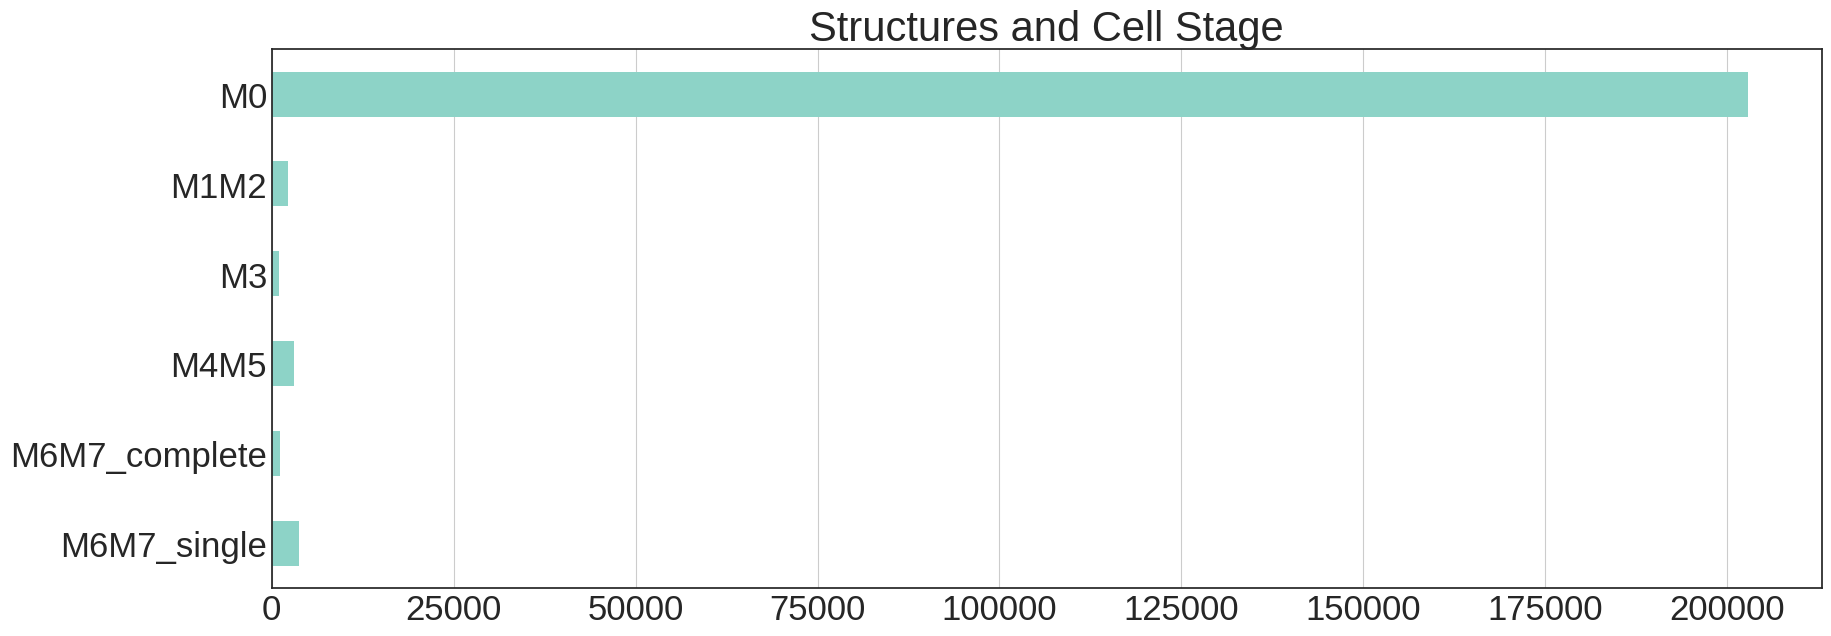

In [3]:
%matplotlib inline
plt.rcParams.update({'font.size': 25})
plt.style.use('seaborn-v0_8-white')   #print(plt.style.available)
# Code from Chapter 4 to make a bar plot
table = pd.pivot_table(df, index="cell_stage", aggfunc="size")
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
table.plot.barh(stacked=True, ax=axes)
axes.set_ylabel(None)
axes.set_title("Structures and Cell Stage")
axes.grid(True, which="major", axis="x")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()

In [4]:
# Print the numbers
print(table)

cell_stage
M0               202847
M1M2               2202
M3                  981
M4M5               3099
M6M7_complete      1198
M6M7_single        3710
dtype: int64


### Make a mitotic dataset for the challenge

In [5]:
#From Chapter 5
#loading library, making path for 
from serotiny.transforms.dataframe.transforms import split_dataframe
Path("/home/aicsuser/serotiny_data/").mkdir(parents=True, exist_ok=True)

# Sample n cells per group
n = 2000 # number of cells per mitotic class
cells_to_include=[]
for name, group in df.groupby('cell_stage'):    
    sampled_group = group.sample(min([n,len(group)]))
    cells_to_include.append(sampled_group)
df_mitocells = pd.concat(cells_to_include).reset_index(drop=True)

# Discarding all the M6M7_single cells
df_mitocells = df_mitocells.drop(df_mitocells[df_mitocells['cell_stage']=='M6M7_single'].index)

# Add the train, test and validate split
df_mitocells = split_dataframe(dataframe=df_mitocells, train_frac=0.7, val_frac=0.2, return_splits=False)

df_mitocells.to_csv("/home/aicsuser/serotiny_data/mitocells.csv") 
print(f"Number of cells: {len(df_mitocells)}")
print(f"Number of columns: {len(df_mitocells.columns)}")

Number of cells: 8179
Number of columns: 78


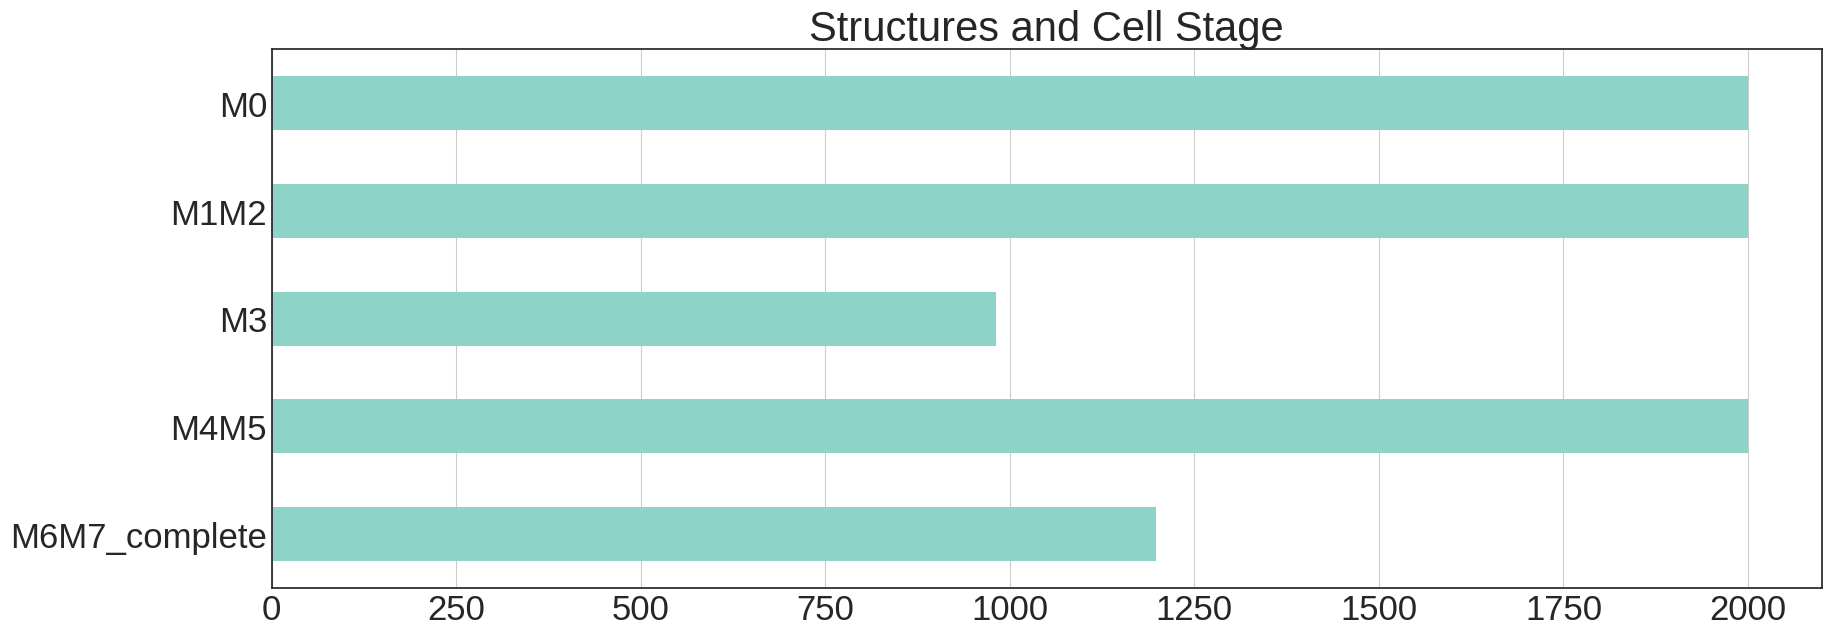

cell_stage
M0               2000
M1M2             2000
M3                981
M4M5             2000
M6M7_complete    1198
dtype: int64


In [6]:
# The bar plot again
%matplotlib inline
plt.style.use('seaborn-v0_8-white')   #print(plt.style.available)
# Code from Chapter 4 to make a bar plot
table = pd.pivot_table(df_mitocells, index="cell_stage", aggfunc="size")
fig, axes = plt.subplots(figsize=(20, 7), dpi=100)
table.plot.barh(stacked=True, ax=axes)
axes.set_ylabel(None)
axes.set_title("Structures and Cell Stage")
axes.grid(True, which="major", axis="x")
axes.set_axisbelow(True)
axes.invert_yaxis()
plt.show()
print(table)

### Why do we remove the M6M7_single cells?

In [ ]:
# From Chapter 3
# Lets sample 20 cells of non edge (0) and edge (1) cells
df_sample = df.loc[df['cell_stage'].isin(['M6M7_complete','M6M7_single'])]
df_sample = df_sample.groupby('cell_stage').apply(lambda x: x.sample(1)).reset_index(drop=True)

In [ ]:
# Now, lets make 2 diagnostic sheets for non edge and edge cells 
# Here we can also specify a feature to be added as text on the plot
# In this example, we plot nuclear height (column name MEM_position_depth)

# This may take some time depending on the number of images being projected
plt.style.use("dark_background")
warnings.simplefilter(action='ignore', category=FutureWarning)

diagnostic_sheet(df_sample, 
                 save_dir = "./", # Created a diagnostic_sheets folder in the current working dir
                 image_column = "3d_image", # Pass in the 3D image path or one of the 2D image paths like max_projection_x
                 max_cells=25, # max cells per sheet
                 channels = [1,2,3], # DNA, Membrane, Structure intensity channels
                 colors = [[0, 1, 1], [1, 0, 1], [1,1,1]], # Cyan, Magenta, White
                 proj_method = "max", # options - max, mean, sum
                 metadata = "cell_stage", # Optional, Metadata to stratify the diagnostic sheets
                 feature = "cell_volume", # Optional, Feature to add as text,
                 fig_width = None, # Default is number of columns * 7
                 fig_height = None, # Default is number of rows * 5,
                 distributed_executor_address = None, # An optional executor address to pass to some computation engine.
                 batch_size = None, # process all at once
                 overwrite=True)




In [ ]:
# Lets load up the saved diagnostic sheets and compare edge and non edge cells
# For a more zoomed in view, click on the image directly and view it in the browser
fig, (ax, ax1) = plt.subplots(1,2,figsize=(20,20))
ax.imshow(plt.imread(os.getcwd() + "/diagnostic_sheets/" + "cell_stage_M6M7_complete_1.png"))
ax1.imshow(plt.imread(os.getcwd() + "/diagnostic_sheets/" + "cell_stage_M6M7_single_1.png"))
ax.set_axis_off()
ax.set_title('M6M7_complete cells')
ax1.set_axis_off()
ax1.set_title('M6M7_single cells')

In [ ]:
# Visualize a cell
# From Chapter 3
import nbvv
from aicsimageprocessing import read_ome_zarr

# Boolean Indexing
a_cell =df[
    (df['gene'] == "TUBA1B") &       #microtubules
    (df['cell_stage'] == "M6M7_complete")    
].sample(1).iloc[0]

full_img = read_ome_zarr(a_cell["3d_image"])
img_data = full_img.data.squeeze()
print(img_data.shape)
channel_names = full_img.channel_names
print(channel_names)

nbvv.volshow(
    img_data,
    spacing=[1,1,1],  # fullb_img.physical_pixel_sizes,
    channel_names=channel_names
)

## <a id='rf'></a> 6.2 Make a simple classifier

In [ ]:
#Adapted from Chapter 4
# Import RF classifier and confusion matrix functionality
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
# Adapt font size of plots
plt.rcParams.update({'font.size': 18})


# Initialize classifer
# clf = RandomForestClassifier(max_depth=2, random_state=0)
clf = RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced')

# Make the dataset (features matrix X and class labels y)
selected_features = ['nuclear_volume','nuclear_height','nuclear_surface_area',
                     'cell_volume','cell_height','cell_surface_area',
                    ]
Xy_train = df_mitocells[df_mitocells['split']=='train'][[*selected_features, 'cell_stage']].dropna(axis=0).to_numpy()
X_train = Xy_train[:,0:-1]
y_train = Xy_train[:,-1]
print(Xy_train.shape)
Xy_test = df_mitocells[df_mitocells['split']=='test'][[*selected_features, 'cell_stage']].dropna(axis=0).to_numpy()
X_test = Xy_test[:,0:-1]
y_test = Xy_test[:,-1]
print(Xy_test.shape)

# Fit the model
clf.fit(X_train, y_train)
# Apply the model (to the training dataset)
y_trainpred = clf.predict(X_train)
# Apply the model (to the test dataset)
y_testpred = clf.predict(X_test)

# Show performance as a confusion matrix
cm_train = confusion_matrix(y_train, y_trainpred, labels = df_mitocells['cell_stage'].unique())                        
cm_test = confusion_matrix(y_test, y_testpred, labels = df_mitocells['cell_stage'].unique())                        

# plot it
labels = df_mitocells['cell_stage'].unique()
cm_train_df = pd.DataFrame(cm_train)
cm_test_df = pd.DataFrame(cm_test)
score_train = accuracy_score(y_test,y_testpred) #compute accuracy score
score_test = accuracy_score(y_train,y_trainpred) #compute accuracy score
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)
#train
sns.heatmap(cm_train_df, annot=True, fmt='d',ax=axes[0])
axes[0].set_title(f'Train accuracy is {score_train:.2f}')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')
axes[0].set_xticklabels([''] + labels)
axes[0].set_yticklabels([''] + labels)
#test
sns.heatmap(cm_test_df, annot=True, fmt='d',ax=axes[1])
axes[1].set_title(f'Test accuracy is {score_test:.2f}')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')
axes[1].set_xticklabels([''] + labels)
axes[1].set_yticklabels([''] + labels)
plt.show()


## <a id='tasks'></a> 6.3 Here are the hackathon tasks

#### Performance and  Feature Interpretation
1 Can you build a more advanced classifier, one with the lowest possible error on the test set?
- Which features (metrics and image channels) boost classification performance?
- Does it help to use 3D images vs 2D images?
  
2 Can you classify cell cycle stage based on the bright-field channel?
  
3 Are there mislabeled cells in the dataset, i.e. cells that are systematically mis-predicted or that appear as outliers given their mitotic stage?
- Are mistakes enriched in a particular cell line?
#### Structure specific tasks
4 If you focus on one specific cell line / marker / structure, e.g. microtubules, can you describe/use differences across the mitotic stages
- Can you use the structure channel within a cell line to distinguish mitotic stages? How does this relate to different structures? Is it easier for one structure vs. another?
#### Latent spaces (advanced ML tasks) 
5 Can you build an auto-encoder for the various cell-cycle stages and generate representative metrics/images for each cell cycle stage?
  
6 Can you build a pseudo-time trajectory and project organelle metrics, such as volume, over the cell cycle?


# <a id='end'></a>Conclusion
In this chapter we prepared the mitotic dataset for the hackathon tasks. Now you are ready to form teams and discuss with your team which task(s) you will tackle and how. The hackacthon assistants are ready to actively engage with you.